In [5]:
from google.cloud import bigquery

client = bigquery.Client()

lengthofstay="""
SELECT
    class.code as encounter_class,
    period.start as start_timestamp,
    period.end as end_timestamp, 
    TIMESTAMP_DIFF(TIMESTAMP(period.end), TIMESTAMP(period.start), HOUR) as length_of_stay_in_hours
FROM 
    fhir_dataset.Encounter
WHERE
    period.end >= period.start
ORDER BY
    4 DESC
LIMIT 10
"""
df = client.query(lengthofstay).to_dataframe()
df.head()

,encounter_class,start_timestamp,end_timestamp,length_of_stay_in_hours
0,AMB,1988-06-17T05:37:51-07:00,1988-07-01T05:37:51-07:00,336
1,AMB,2015-08-04T05:37:51-07:00,2015-08-04T10:52:51-07:00,5
2,EMER,2018-01-15T03:55:48-08:00,2018-01-15T09:10:48-08:00,5
3,AMB,2007-11-13T04:37:51-08:00,2007-11-13T09:52:51-08:00,5
4,EMER,2016-03-26T16:25:32-07:00,2016-03-26T19:49:32-07:00,3


In [6]:
observation="""
SELECT
  cc.code loinc_code,
  cc.display loinc_name,
  approx_quantiles(round(o.value.quantity.value,1),4) as quantiles,
  count(*) as num_obs
FROM
  fhir_dataset.Observation o, o.code.coding cc
WHERE
  cc.system like '%loinc%' and lower(cc.display) like '%cholesterol%'
GROUP BY 1,2
ORDER BY 4 desc
"""
df2 = client.query(observation).to_dataframe()
df2.head()

,loinc_code,loinc_name,quantiles,num_obs
0,2085-9,High Density Lipoprotein Cholesterol,"[62.2, 64.4, 68.2, 76.9, 79.9]",10
1,2093-3,Total Cholesterol,"[166.9, 176.2, 177.3, 184.0, 199.2]",10
2,18262-6,Low Density Lipoprotein Cholesterol,"[67.9, 74.6, 79.8, 91.2, 113.6]",10


In [7]:
encounters="""
SELECT
  encounter_class,
  APPROX_QUANTILES(num_encounters, 4) num_encounters_quantiles
FROM (
  SELECT
    class.code encounter_class,
    subject.reference patient_id,
    COUNT(DISTINCT id) AS num_encounters
  FROM
    fhir_dataset.Encounter
  GROUP BY
    1,2
  )
GROUP BY 1
ORDER BY 1
"""
df3 = client.query(encounters).to_dataframe()
df3.head()

,encounter_class,num_encounters_quantiles
0,AMB,"[251, 251, 251, 251, 251]"
1,EMER,"[14, 14, 14, 14, 14]"


In [8]:
avgstay="""
SELECT
  class.code encounter_class,
  ROUND(AVG(TIMESTAMP_DIFF(TIMESTAMP(period.end), TIMESTAMP(period.start), MINUTE)),1) as avg_minutes
FROM
  fhir_dataset.Encounter
WHERE
  period.end >= period.start
GROUP BY
  1
ORDER BY
  2 DESC
  """
df4 = client.query(avgstay).to_dataframe()
df4.head()

,encounter_class,avg_minutes
0,AMB,109.5
1,EMER,108.1


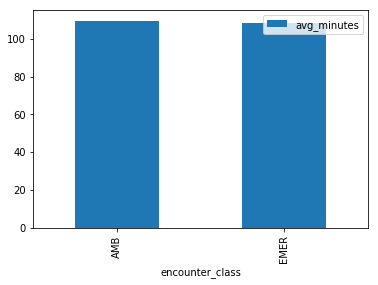

In [9]:
df4.plot(kind='bar', x='encounter_class', y='avg_minutes');